In [3]:
# Import libraries and dependencies
import os
import pandas as pd
import alpaca_trade_api as tradeapi
from pathlib import Path
import seaborn as sns
# Load .env environment variables
from dotenv import load_dotenv
load_dotenv()

%matplotlib inline

In [4]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [3]:
# set tickers for Amazon, Facebook, NVidia, Walmart, and Goldman Sachs
ticker = ["AMZN", "FB", "NVDA", "WMT", "GS", "SNP"]


# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp("2021-01-28", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2022-01-28", tz="America/New_York").isoformat()

# Get 1 year's worth of historical data for all tickers
df_ticker = alpaca.get_barset(
    ticker,
    timeframe,
    start=start_date,
    end=end_date,
    limit=1000,
).df

# Display sample data
df_ticker.head()

AMZN                                       \
                              open     high       low    close   volume   
time                                                                      
2021-01-28 00:00:00-05:00  3235.04  3301.68  3228.690  3239.70  2742821   
2021-01-29 00:00:00-05:00  3230.00  3236.99  3184.550  3206.31  2855494   
2021-02-01 00:00:00-05:00  3242.36  3350.26  3235.025  3342.88  3734204   
2021-02-02 00:00:00-05:00  3380.00  3427.74  3361.125  3383.23  5024907   
2021-02-03 00:00:00-05:00  3425.01  3434.00  3308.620  3311.26  6445905   

                               FB                                    ...  \
                             open    high     low   close    volume  ...   
time                                                                 ...   
2021-01-28 00:00:00-05:00  277.18  286.79  264.70  265.00  35383730  ...   
2021-01-29 00:00:00-05:00  265.30  266.56  254.85  258.33  28139673  ...   
2021-02-01 00:00:00-05:00  259.52  264.17  254.91  261.98  19629047  ...   
2021-02-02 00:00:00-05:00  264.00  268.85  263.27  267.00  15002887  ...   
2021-02-03 00:00:00-05:00  265.62  269.20  263.84  266.68  13254318  ...   

                             SNP                                  WMT          \
                            open   high    low  close  volume    open    high   
time                                                                            
2021-01-28 00:00:00-05:00  48.79  49.20  48.31  48.71  174384  144.46  146.26   
2021-01-29 00:00:00-05:00  48.02  48.20  47.31  47.42  108463  143.18  143.75   
2021-02-01 00:00:00-05:00  47.98  48.29  47.59  48.00  118111  140.91  141.49   
2021-02-02 00:00:00-05:00  48.64  48.82  48.20  48.64  112467  139.76  142.15   
2021-02-03 00:00:00-05:00  48.81  49.01  48.60  48.94  100934  140.66  142.05   

                                                        
                                low     close   volume  
time                                                    
2021-01-28 00:00:00-05:00  143.6300  143.7000  6207997  
2021-01-29 00:00:00-05:00  140.3500  140.4693  8553315  
2021-02-01 00:00:00-05:00  139.1900  139.2400  7663421  
2021-02-02 00:00:00-05:00  139.4401  140.7700  8332687  
2021-02-03 00:00:00-05:00  140.6300  141.1900  4483616  

[5 rows x 30 columns]

In [4]:
# Create an empty DataFrame for closing prices
df_closing_prices = pd.DataFrame()

# Fetch the closing prices of all stocks
df_closing_prices["AMZN"] = df_ticker["AMZN"]["close"]
df_closing_prices["FB"] = df_ticker["FB"]["close"]
df_closing_prices["NVDA"] = df_ticker["NVDA"]["close"]
df_closing_prices["WMT"] = df_ticker["WMT"]["close"]
df_closing_prices["GS"] = df_ticker["GS"]["close"]
df_closing_prices["SNP"] = df_ticker["SNP"]["close"]

# Drop the time component of the date
df_closing_prices.index = df_closing_prices.index.date

# Compute daily returns
df_daily_returns = df_closing_prices.pct_change().dropna()

# Display sample data
df_daily_returns.head()

,AMZN,FB,NVDA,WMT,GS,SNP
2021-01-29,-0.010307,-0.025170,-0.005556,-0.022482,-0.014142,-0.026483
2021-02-01,0.042594,0.014129,0.020134,-0.008751,0.012685,0.012231
2021-02-02,0.012070,0.019162,0.024175,0.010988,0.044716,0.013333
2021-02-03,-0.021273,-0.001199,-0.002139,0.002984,0.005716,0.006168
2021-02-04,0.005913,-0.000187,0.010072,0.009491,0.019339,-0.003882


In [5]:
# Generate descriptive statistics
df_daily_returns.describe()

,AMZN,FB,NVDA,WMT,GS,SNP
count,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000
mean,-0.000343,0.000682,-0.000308,-0.000117,0.001049,0.000391
std,0.015716,0.018493,0.055562,0.010670,0.016146,0.017501
min,-0.075683,-0.050560,-0.752313,-0.066287,-0.070219,-0.054496
25%,-0.009262,-0.010711,-0.013533,-0.005894,-0.010182,-0.010070
50%,-0.000372,-0.000122,0.002631,0.000215,-0.000114,0.000984
75%,0.009810,0.013769,0.020068,0.006335,0.010920,0.011097
max,0.046918,0.072938,0.120540,0.028626,0.044716,0.069929


<AxesSubplot:ylabel='Frequency'>

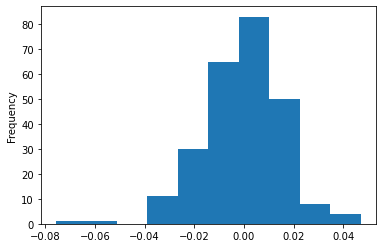

In [6]:
# Visualize distribution of Amazon percent change in closing price using a histogram plot
df_daily_returns["AMZN"].plot.hist()

<AxesSubplot:ylabel='Frequency'>

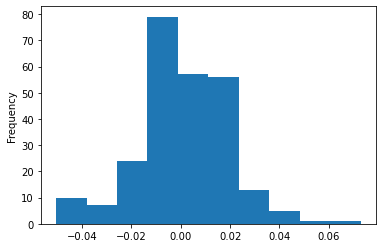

In [7]:
# Visualize distribution of FaceBook percent change in closing price using a histogram plot
df_daily_returns["FB"].plot.hist()

<AxesSubplot:ylabel='Frequency'>

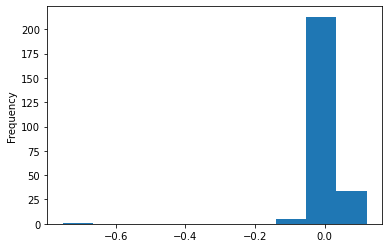

In [8]:
# Visualize distribution of NVidia percent change in closing price using a histogram plot
df_daily_returns["NVDA"].plot.hist()

<AxesSubplot:ylabel='Frequency'>

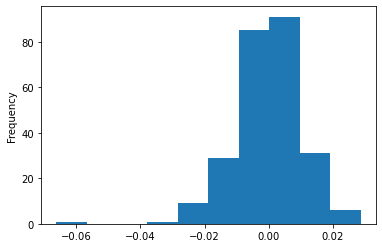

In [9]:
# Visualize distribution of WalMart percent change in closing price using a histogram plot
df_daily_returns["WMT"].plot.hist()

<AxesSubplot:ylabel='Frequency'>

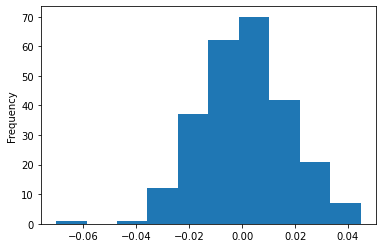

In [10]:
# Visualize distribution of Goldman Sachs percent change in closing price using a histogram plot
df_daily_returns["GS"].plot.hist()

<AxesSubplot:>

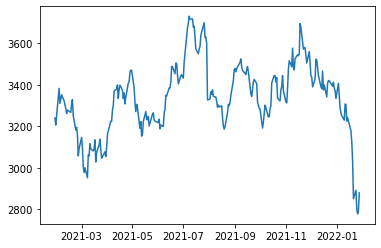

In [11]:
df_closing_prices["AMZN"].plot()

<AxesSubplot:>

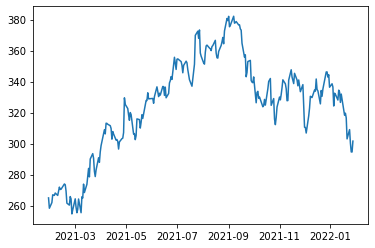

In [12]:
df_closing_prices["FB"].plot()

<AxesSubplot:>

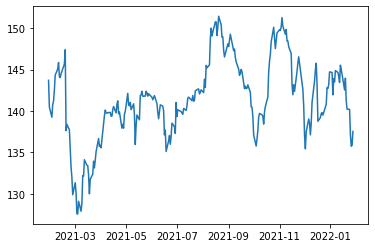

In [13]:
df_closing_prices["WMT"].plot()

<AxesSubplot:>

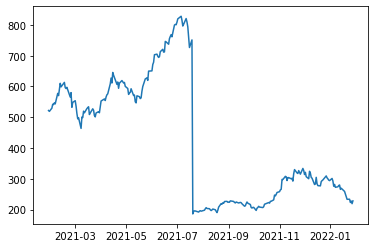

In [14]:
df_closing_prices["NVDA"].plot()

<AxesSubplot:>

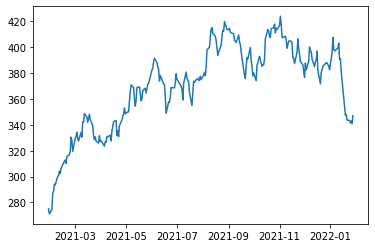

In [15]:
df_closing_prices["GS"].plot()

<AxesSubplot:>

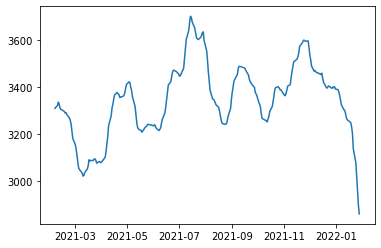

In [16]:
# Plot a rolling 7-day mean of Amazon closing prices
df_closing_prices["AMZN"].rolling(window=7).mean().plot()

<AxesSubplot:>

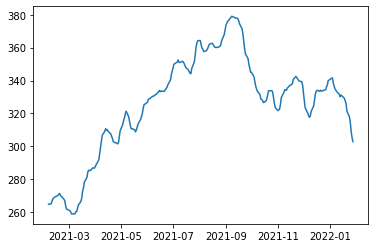

In [17]:
# Plot a rolling 7-day mean of FaceBook closing prices
df_closing_prices["FB"].rolling(window=7).mean().plot()

<AxesSubplot:>

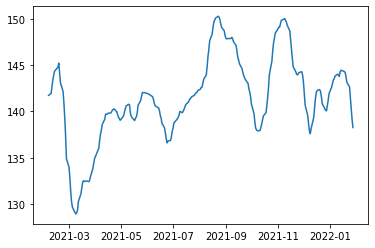

In [18]:
# Plot a rolling 7-day mean of WalMArt closing prices
df_closing_prices["WMT"].rolling(window=7).mean().plot()

<AxesSubplot:>

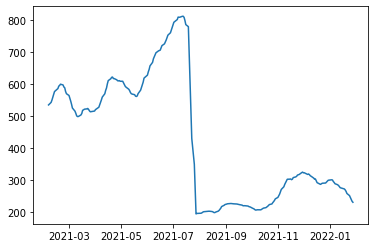

In [19]:
# Plot a rolling 7-day mean of NVidia closing prices
df_closing_prices["NVDA"].rolling(window=7).mean().plot()

<AxesSubplot:>

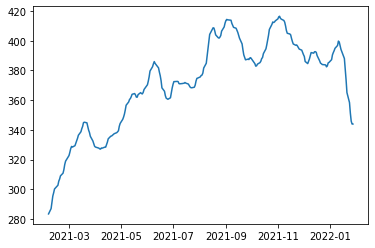

In [20]:
# Plot a rolling 7-day mean of Goldman Sachs closing prices
df_closing_prices["GS"].rolling(window=7).mean().plot()

<AxesSubplot:>

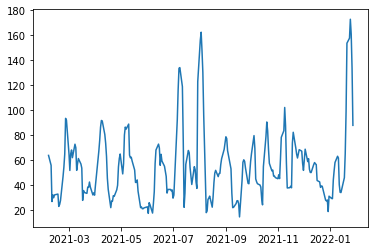

In [21]:
# Plot a rolling 7-day std dev of Amazon closing prices
df_closing_prices["AMZN"].rolling(window=7).std().plot()

<AxesSubplot:>

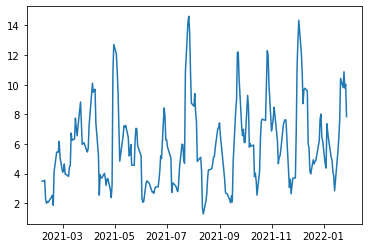

In [22]:
# Plot a rolling 7-day std dev of FaceBook closing prices
df_closing_prices["FB"].rolling(window=7).std().plot()

<AxesSubplot:>

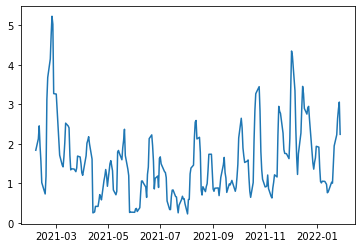

In [23]:
# Plot a rolling 7-day std dev of WalMart closing prices
df_closing_prices["WMT"].rolling(window=7).std().plot()

<AxesSubplot:>

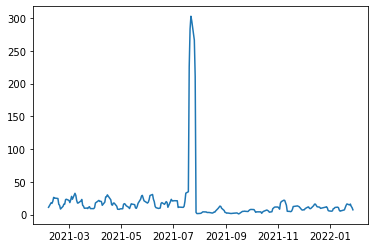

In [24]:
# Plot a rolling 7-day std dev of NVidia closing prices
df_closing_prices["NVDA"].rolling(window=7).std().plot()

<AxesSubplot:>

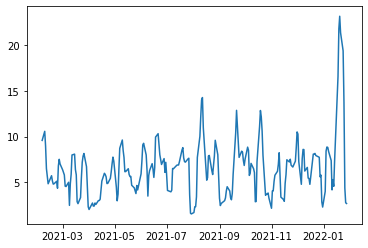

In [25]:
# Plot a rolling 7-day std dev of Goldman Sachs closing prices
df_closing_prices["GS"].rolling(window=7).std().plot()

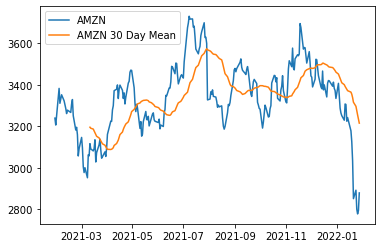

In [26]:
# Set figure of the daily closing prices of AMZN
ax = df_closing_prices["AMZN"].plot()

# Plot 180-Day Rolling Mean on the same figure
df_closing_prices["AMZN"].rolling(window=30).mean().plot(ax=ax)

# Set the legend of the figure
ax.legend(["AMZN", "AMZN 30 Day Mean"])

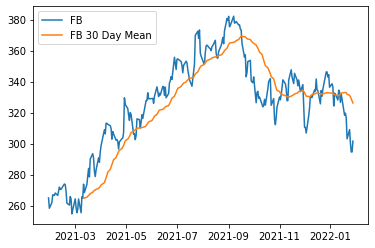

In [27]:
# Set figure of the daily closing prices of FB
ax = df_closing_prices["FB"].plot()

# Plot 180-Day Rolling Mean on the same figure
df_closing_prices["FB"].rolling(window=30).mean().plot(ax=ax)

# Set the legend of the figure
ax.legend(["FB", "FB 30 Day Mean"])

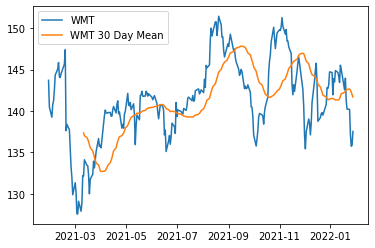

In [28]:
# Set figure of the daily closing prices of WMT
ax = df_closing_prices["WMT"].plot()

# Plot 180-Day Rolling Mean on the same figure
df_closing_prices["WMT"].rolling(window=30).mean().plot(ax=ax)

# Set the legend of the figure
ax.legend(["WMT", "WMT 30 Day Mean"])

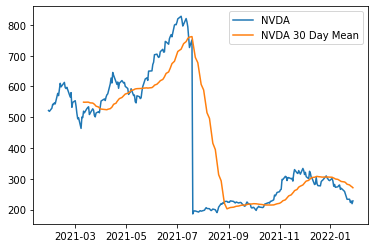

In [29]:
# Set figure of the daily closing prices of NVDA
ax = df_closing_prices["NVDA"].plot()

# Plot 180-Day Rolling Mean on the same figure
df_closing_prices["NVDA"].rolling(window=30).mean().plot(ax=ax)

# Set the legend of the figure
ax.legend(["NVDA", "NVDA 30 Day Mean"])

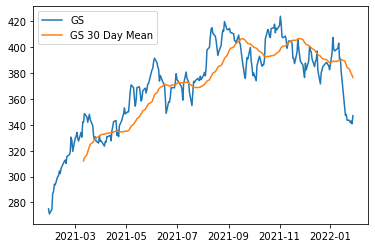

In [30]:
# Set figure of the daily closing prices of GS
ax = df_closing_prices["GS"].plot()

# Plot 180-Day Rolling Mean on the same figure
df_closing_prices["GS"].rolling(window=30).mean().plot(ax=ax)

# Set the legend of the figure
ax.legend(["GS", "GS 30 Day Mean"])

<AxesSubplot:>

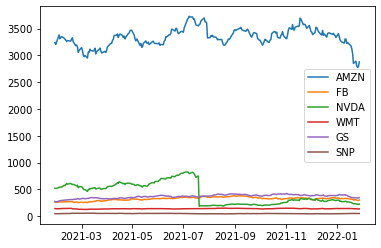

In [31]:
df_closing_prices.plot()

<AxesSubplot:xlabel='AMZN', ylabel='SNP'>

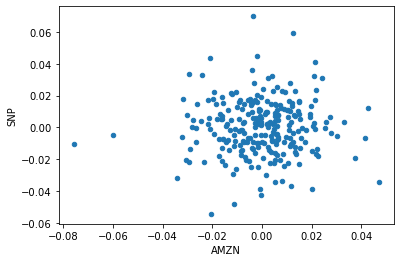

In [32]:
df_daily_returns.plot(kind='scatter', x='AMZN', y='SNP')

In [33]:
# Calculate covariance of all daily returns of AMZN vs. SNP
covariance = df_daily_returns['AMZN'].cov(df_daily_returns['SNP'])
covariance

5.398149847134084e-06

In [34]:
# Calculate variance of the S&P 500
variance = df_daily_returns['SNP'].var()
variance

0.0003062696100545882

In [35]:
# Calculate beta of all daily returns of AMZN
AMZN_beta = covariance / variance
AMZN_beta

0.01762548313615556

<AxesSubplot:title={'center':'Rolling 30-Day Covariance of Amazon Returns vs. S&P 500 Returns'}>

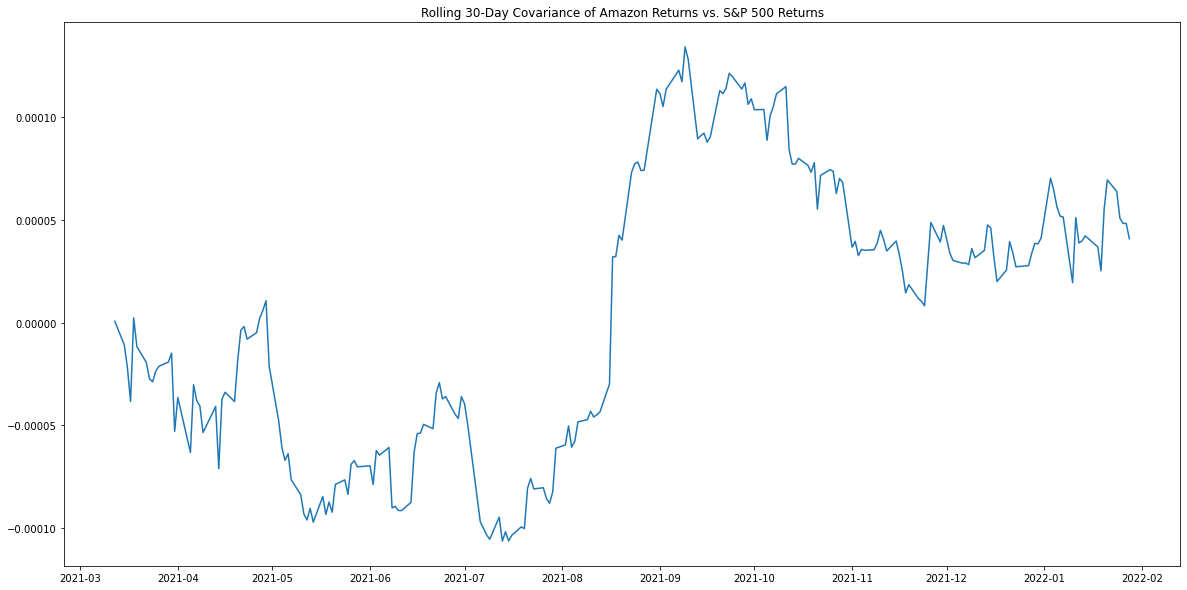

In [36]:
# Calculate 30-day rolling covariance of AMZN vs. SPN and plot the data
AMZN_rolling_covariance = df_daily_returns['AMZN'].rolling(window=30).cov(df_daily_returns['SNP'])
AMZN_rolling_covariance.plot(figsize=(20, 10), title='Rolling 30-Day Covariance of Amazon Returns vs. S&P 500 Returns')

<AxesSubplot:title={'center':'Rolling 30-Day Variance of S&P 500 Returns'}>

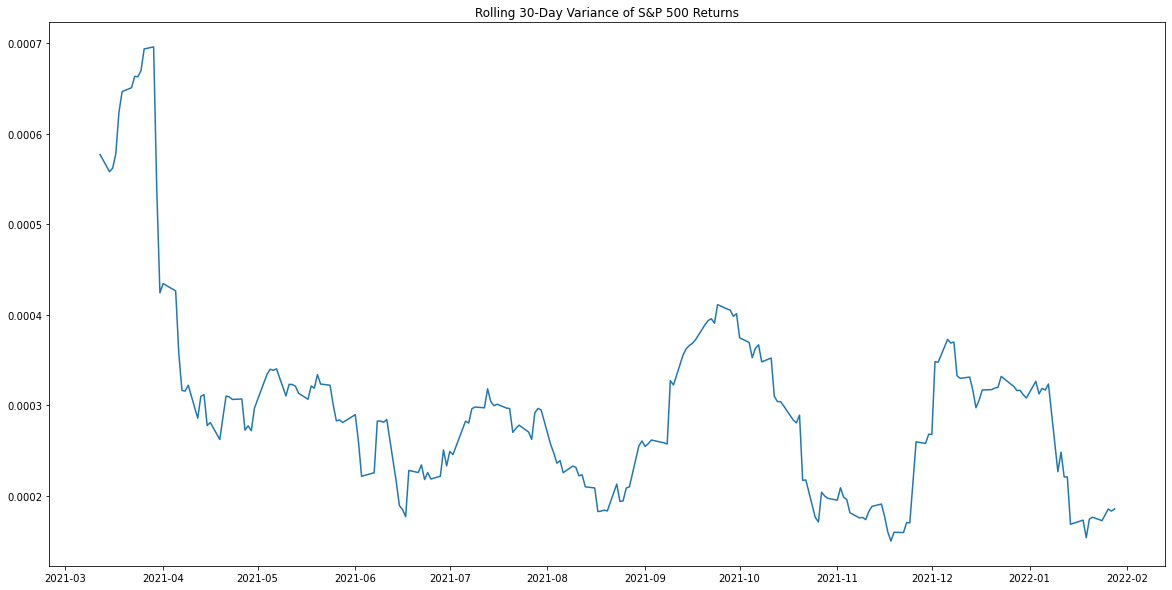

In [37]:
# Calculate 30-day rolling variance of MSFT vs. S&P 500 and plot the data
rolling_variance = df_daily_returns['SNP'].rolling(window=30).var()
rolling_variance.plot(figsize=(20, 10), title='Rolling 30-Day Variance of S&P 500 Returns')

<AxesSubplot:title={'center':'Rolling 30-Day Beta of AMZN'}>

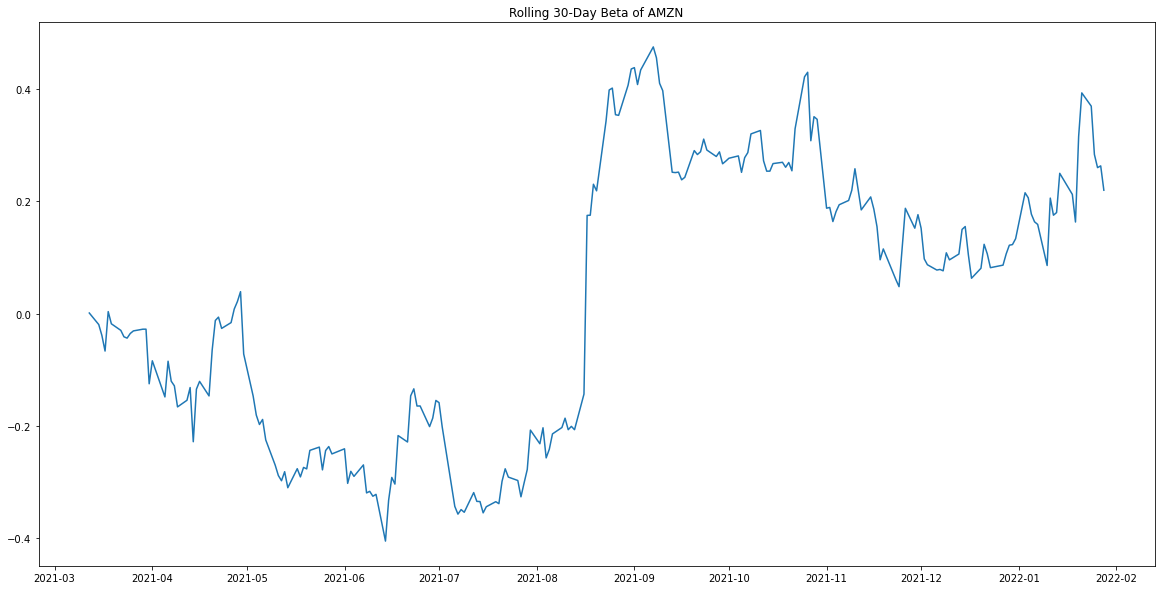

In [38]:
# Calculate 30-day rolling beta of MSFT and plot the data
rolling_beta = AMZN_rolling_covariance / rolling_variance
rolling_beta.plot(figsize=(20, 10), title='Rolling 30-Day Beta of AMZN')

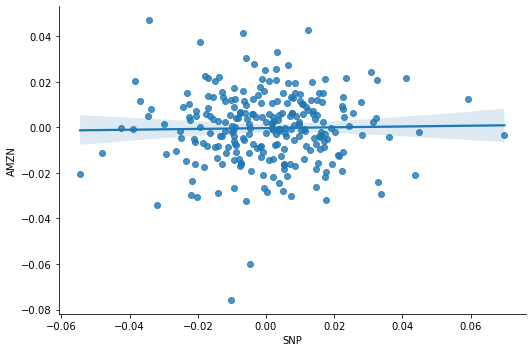

In [39]:
# Showcase beta vs. correlation by plotting a scatterplot using the seaborn library and fitting a regression line
sns.lmplot(x='SNP', y='AMZN', data=df_daily_returns, aspect=1.5, fit_reg=True)

In [40]:
# cumulative returns
cumulative_returns = (1 + df_daily_returns).cumprod() - 1
cumulative_returns.head()

,AMZN,FB,NVDA,WMT,GS,SNP
2021-01-29,-0.010307,-0.025170,-0.005556,-0.022482,-0.014142,-0.026483
2021-02-01,0.031849,-0.011396,0.014466,-0.031037,-0.001636,-0.014576
2021-02-02,0.044303,0.007547,0.038990,-0.020390,0.043007,-0.001437
2021-02-03,0.022088,0.006340,0.036767,-0.017467,0.048969,0.004722
2021-02-04,0.028132,0.006151,0.047209,-0.008142,0.069255,0.000821


<AxesSubplot:>

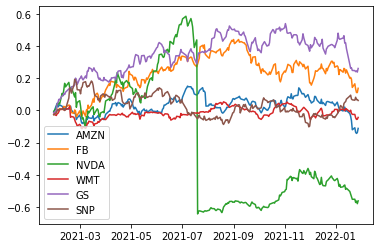

In [41]:
cumulative_returns.plot()